# Graph-based image segmentation
---

The following code is based on the graph-based segmentation algorithm proposed by Felzenszwalb et. al. ([paper](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf)).

## Description of the algorithm

Let's consider a grayscale image of size `NxM`, being N the height of the image and M its width. Each pixel of the image has a value between 0 and 255.

The algorithm treats each pixel as a node of a graph `G = (V,E)` where:
- `V` is the set of vertices
- `E` the set of edges (i.e. connections between a pair of nodes).

Each edge has an associated weight which - in the case of this implementation - is the *intensity distance* between the considered pair of nodes.

The pixels are connected in a 8-grid fashion: this means that each pixel is connected to its 8 neighbors.

We start by considering each node of the graph as a singleton component (at the beginning we have `height * width` components) and we merge them is an agglomerative way according to the so called *boundary evidence*.

That is: at each step of the algorithm, two components are compared and, if a boundary evidence is present, they are keep separated, otherwise they are merged into one single components. Doing so, we can reduce the number of components step-by-step reaching a final result in which each component represents a logic instance in the image.

The boundary evidence is defined as the inequality between two quantities:
- `Dif(C1, C2)`: represents the within-difference between the two components `C1` and `C2`
- `MInt(C1, C2)`: represents the inter-component difference

For more details see the [paper](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf).

For our purpose it is important to notice that the threshold depends on a parameter `k` which can be considered as a *tuning* parameter:
- larger `k`: preference for larger components
- smaller `k`: preference for smaller components

In [1]:
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw
import time

### Disjoint-set forest

The components are well represented using the *disjoint-set forest* data structure:
- it stores a collection of disjoint non-overlapping sets (or a partition of a set into disjoint subsets).
- provides operations for:
    - adding new sets
    - merging sets (replacing them by their union) 
    - find a representative member of a set. 


It works as follows:
- the set is initialized with `N * M` nodes, each of one is initially considered as a single components (or subset)
- each component has a representative/parent which is the one having greater rank
- when two components are merged into a single one, the one having greater rank is considered the parent of the other
- the size of a component indicats the number of nodes inside it


In [2]:
class DisjointSetForest:
    ''' 
    Disjoint-set forest data structure (https://en.wikipedia.org/wiki/Disjoint-set_data_structure).
    Stores a collection of disjoint non-overlapping sets (or a partition of a set into disjoint subsets).
    Provides operations for adding new sets, merging sets (replacing them by their union) and find a 
    representative member of a set. 
    '''

    def __init__(
          self
        , num_nodes: int
        ) -> None:
        ''' 
        Disjoint-set forest class constructor.

        Args:
            num_nodes (int): total number of elements to be partitioned.
        '''
        # list providing the parent of the indexed node (list)
        self.parent = [i for i in range(num_nodes)]

        # list providing the rank of the indexed node (list)
        self.rank = [0 for i in range(num_nodes)]

        # list providing the size of the child tree of the indexed node (list)
        self.size = [1 for i in range(num_nodes)]


    
    def size_of(  
          self
        , u: int
        ) -> int:
        ''' 
        Return the size of the child tree of the given component 
        
        Args:
            u (int): node of which we want to know the size.
        
        Returns:
            size (int): number of nodes in the subtree of u.    
        '''
        return self.size[u]



    def find(
        self
        , u: int
        ) -> int:
        ''' 
        Return the representative of a subset.

        Args:
            u (int): node of which we want to know the representative.

        Returns:
            representative of the subset/node.
        '''
        if self.parent[u] == u:
            return u

        self.parent[u] = self.find(self.parent[u])
        return self.parent[u]



    def merge(
          self
        , u: int
        , v: int
        ) -> None:
        ''' 
        Merge two nodes/subsets into one based on their rank.

        Args:
            u (int): first node/subset
            v (int): second node/subset
        '''
        u = self.find(u)
        v = self.find(v)

        if u != v:
            if self.rank[u] > self.rank[v]:
                u, v = v, u

            self.parent[u] = v
            self.size[v] += self.size[u]
            if self.rank[u] == self.rank[v]:
                self.rank[v] += 1



    def num_components(self) -> int:
        ''' 
        Return the number of current components.
        
        Returns:
            num_components (int): number of current components
        '''
        return len(self.parents())



    def parents(self) -> list:
        ''' 
        Return the parent nodes.

        Returns:
            parents (list): list of parent nodes
        '''
        return list(set(self.parent))



    def sorted_parents(self) -> list:
        ''' 
        Return the parents nodes sorted by size in descreasing order.

        Returns:
            sorted_parents (list): list of sorted parent nodes
        '''
        return sorted(
                      self.parents()
                    , key=lambda parent: 
                            self.size_of(parent)
                    , reverse=True
                    )

### Graph

The implementation of the `GraphBasedSegmentation` class is useful to convert an input image into a graph which can be exploited to run the graph-based segmentation algorithm.

The class provides the following methods:
- `_preprocessing()`: converts an input RGB image to a grayscale Numpy array and apply some preprocessing operations.
- `_get_diff(pixel1, pixel2)`: returns the difference in terms of intensity between the given pixels.
- `_create_edge(pixel1, pixel2)`: creates the edge between two pixels of the input image.
- `_threshold(k, size)`: defines the threshold for a component havig size = size with the constant k (`t = k/size`).
- `build_graph()`: builds the graph (list of tuples) from the input image, adding the necessary edges.
- `sort()`: sorts the graph according to the weights of the edges (non-decreasing order).
- `segment(k, min_size)`: segments the image applying the algorithm and removes the component with `size < min_size`.
- `generate_image()`: generates the segmented image.
- `find_boundaries()`: found the boundaries of the regions of the segmented image.
- `draw_boxes()`: draw rectangular boxes around each region.

In [3]:
class GraphBasedSegmentation:
    ''' 
    Class for the implementation of the graph-based segmentation algorithm.
    A graph is built starting from an input image.
    Each pixel is a vertex of G = (V, E) where G is the graph, V is the set of
    vertices and E is the set of edges. Each pixel is connected to its neighbors in
    an 8-grid sense.
    Then the algorithm is applied exploiting the disjoint-set forest structure.
    '''

    def __init__(
          self
        , img: str or np.ndarray
        ) -> None:
        ''' 
        GraphBasedSegmentation class constructor.

        Args:
            img (str or np.ndarray): path to the input image (if preprocessing == True)
                                     or np.ndarray of the input image (already preprocessed)
        '''
        # from path
        # ---------------------------------
        if type(img) == str:
            self.img = Image.open(img)
        # ---------------------------------

        # from array
        # ---------------------------------
        elif type(img) == np.ndarray:
            self.img = Image.fromarray(img)
        # ---------------------------------

        # wrong input
        # ---------------------------------
        else:
            raise ValueError("Wrong image type: must be either str or np.ndarray.")
        # ---------------------------------

        self.img_width, self.img_height = self.img.size
    


    @staticmethod
    def __preprocessing(
          img: Image
        , contrast: float=1.5
        , gaussian_blur: float=2.3
        , width: int=300
        , height: int=None
        ) -> np.ndarray:
        ''' 
        Convert an input RGB image to a grayscale Numpy array and apply some preprocessing operations.

        Args:
            img (PIL.Image): image to be processed
            constrast (float): (defualt=1.5) contrast filter
            gaussian_blur (float): (default=1.5) Gaussian Blur filter
            width (int): (default=300) new image width
            height (int): (default=None) new image height
        
        Returns:
            img (np.ndarray): Numpy array represented the preprocessed image
        '''
        # grayscale conversion
        # ---------------------------------
        img = img.convert("L")
        # ---------------------------------
        
        # gaussian blur
        # ---------------------------------
        img = img.filter(ImageFilter.GaussianBlur(gaussian_blur))
        # ---------------------------------

        # contrast
        # ---------------------------------
        img = ImageEnhance.Contrast(img).enhance(contrast)
        # ---------------------------------

        # resize
        # ---------------------------------
        if height is None:
            percentage = float(width / img.size[0])
            height = int((float(img.size[1]) * float(percentage)))
        img = img.resize((width, height), Image.ANTIALIAS)
        # ---------------------------------
        
        return np.array(img)



    @staticmethod
    def __get_diff(
          img: np.ndarray
        , u_coords: tuple
        , v_coords: tuple
        ) -> np.uint8:
        ''' 
        Return the difference in terms of intensity between two pixels of an image.
        
        Args:
            img (numpy.ndarray): input grayscale image in array format (values from 0 to 255)
            u_coords (tuple): coordinates of first pixel (x1, y1)
            v_coords (tuple): coordinates of second pixel (x2, y2)

        Returns:
            diff (numpy.uint8): difference between the input pixels
        '''
        x1, y1 = u_coords
        x2, y2 = v_coords
        
        # necessary check since pixels are uint8 (problem with abs)
        if img[y1, x1] > img[y2, x2]:
            return img[y1, x1] - img[y2, x2]
        
        return img[y2, x2] - img[y1, x1]



    @staticmethod
    def __create_edge(
          img: np.ndarray
        , u_coords: tuple
        , v_coords: tuple
        ) -> tuple:
        ''' 
        Create the edge between two pixels of the input image.

        Args:
            img (numpy.ndarray): input grayscale image in array format (values from 0 to 255)
            u_coords (tuple): coordinates of first pixel (x1, y1)
            v_coords (tuple): coordinates of second pixel (x2, y2)

        Returns:
            id1 (int): first pixel id
            id2 (int): second pixel id
            weight (numpy.uint8): edge weight
        '''
        _, width = img.shape

        vertex_id = lambda coords: coords[1] * width + coords[0]
        id1 = vertex_id(u_coords)
        id2 = vertex_id(v_coords)

        weight = GraphBasedSegmentation.__get_diff(img, u_coords, v_coords)
        
        return (id1, id2, weight)

    

    @staticmethod
    def __threshold(
          k: int
        , size: int
        ) -> int:
        ''' 
        Define the threshold for a subset of cardinality given by size.

        Args:
            k (int): scale of observation (large k -> larger components)
            size (int): cardinality of the component into consideration
        
        Returns:
            threshold (int): threshold for a given component
        '''
        return int(k/size)



    def __build_graph(self) -> None:
        ''' 
        Build the graph.

        Returns:
            graph (list): list of tuples (u, v, weight) 
        '''
        self.graph = []

        print("Building graph...")
        start = time.time()

        for y in range(self.height):
            for x in range(self.width):

                # all columns except last one -> east connection 
                if x < self.width - 1:
                    u_coords = (x, y)
                    v_coords = (x + 1, y)
                    self.graph.append(GraphBasedSegmentation.__create_edge(self.preprocessed_arr, u_coords, v_coords))

                # all rows except last one -> south connection
                if y < self.height - 1:
                    u_coords = (x, y)
                    v_coords = (x, y + 1)
                    self.graph.append(GraphBasedSegmentation.__create_edge(self.preprocessed_arr, u_coords, v_coords))

                # all columns and rows except last ones -> south-east connection
                if x < self.width - 1 and y < self.height - 1:
                    u_coords = (x, y)
                    v_coords = (x + 1, y + 1)
                    self.graph.append(GraphBasedSegmentation.__create_edge(self.preprocessed_arr, u_coords, v_coords))

                # all columns except last one, all rows except first -> north-est connection
                if x < self.width - 1 and y > 0:
                    u_coords = (x, y)
                    v_coords = (x + 1, y - 1)
                    self.graph.append(GraphBasedSegmentation.__create_edge(self.preprocessed_arr, u_coords, v_coords))

        end = time.time()
        print("Graph built in {:.3}s.\n".format(end-start))
    


    def __sort(self) -> None:
        ''' 
        Sort the graph by non-decreasing order of edges' weight.
        '''
        self.sorted_graph = sorted(
                                  self.graph
                                , key=lambda edge: edge[2]
                                )

    

    def segment(
          self
        , k: int=4000
        , min_size: int=100
        , preprocessing: bool=True
        , **kwargs
        ) -> None:
        ''' 
        Segment the graph according to the graph-based segmentation algorithm
        proposed by Felzenszwalb et. al.

        Args:
            k (int): (default=4000) parameter for the threshold
            min_size (int): (default=100) if specified, the components having size less than min_size are removed
                                          if None, the removal is not applied
            preprocessing (bool): (default=True) to be applied if the image has not been preprocessed yet
        '''
        # preprocessing
        # ---------------------------------
        if preprocessing:
            self.preprocessed_arr = GraphBasedSegmentation.__preprocessing(self.img, **kwargs)
        # ---------------------------------
        
        # not preprocessing
        # ---------------------------------
        else:
            self.preprocessed_arr = self.img
            self.preprocessed_arr = self.preprocessed_arr.convert("L")
            self.preprocessed_arr = np.array(self.preprocessed_arr)
        # ---------------------------------

        self.height, self.width = self.preprocessed_arr.shape
        self.num_nodes = self.height * self.width

        # Disjoint-set forest initialization
        # ---------------------------------
        self.components = DisjointSetForest(self.num_nodes)
        # ---------------------------------

        # threshold list
        threshold = [GraphBasedSegmentation.__threshold(k, i) for i in self.components.size]

        # graph build and sorting by non-decreasing order of weights
        # ---------------------------------
        self.__build_graph()
        self.__sort()
        # ---------------------------------


        print("Segmenting...")
        start = time.time()

        for edge in self.sorted_graph:
            u, v, w = edge

            u = self.components.find(u)
            v = self.components.find(v)

            if u != v:
                # boundary evidence check
                if w <= threshold[u] and w <= threshold[v]:
                    self.components.merge(u, v)
                    parent = self.components.find(u)
                    threshold[parent] = w + GraphBasedSegmentation.__threshold(k, self.components.size_of(u))

        end = time.time()
        print("Segmentation done in {:.3}s.\n".format(end-start))

        # remove components having size less than min_size
        # ---------------------------------
        if min_size is not None:

            print("Removing componentes having size less than {}...".format(min_size))
            start = time.time()

            for edge in self.sorted_graph:
                u, v, _ = edge
                u = self.components.find(u)
                v = self.components.find(v)

                if u != v:
                    if self.components.size_of(u) < min_size or self.components.size_of(v) < min_size:
                        self.components.merge(u, v)

            end = time.time()
            print("Removed components in {:.3}s.\n".format(end-start))
        # ---------------------------------
        

    
    def __create_segmented_arr(self) -> None:
        ''' 
        Create the array containing the correspondent parent for each node.
        '''
        parents = self.components.parents()

        self.segmented_arr = np.zeros((self.height, self.width), np.uint8)
        
        print("Defining regions...")
        start = time.time()

        for y in range(self.height):
            for x in range(self.width):
                self.segmented_arr[y, x] = parents.index(self.components.parent[y * self.width + x])
        
        end = time.time()
        print("Regions defined in {:.3}s.\n".format(end-start))



    def generate_image(self) -> None:
        ''' 
        Generate the segmented image as a numpy array.
        '''
        # random color creating (3 levels of values between 0 and 255)
        # ---------------------------------
        random_color = lambda: (int(np.random.rand() * 255), int(np.random.rand() * 255), int(np.random.rand() * 255))
        color = [random_color() for i in range(self.components.num_components())]
        # ---------------------------------

        self.segmented_img = np.zeros((self.height, self.width, 3), np.uint8)

        if not hasattr(self, 'segmented_arr'):
            self.__create_segmented_arr()

        print("Generating image...")
        start = time.time()

        for y in range(self.height):
            for x in range(self.width):
                self.segmented_img[y, x] = color[self.segmented_arr[y, x]]
        
        self.segmented_img = Image.fromarray(self.segmented_img)

        end = time.time()
        print("Image generated in {:.3}s.\n".format(end-start))



    def __find_boundaries(self) -> None:
        ''' 
        Find the boundary of each region in the segmented image.
        '''

        self.boundaries = {}

        for i in range(self.components.num_components()):
            self.boundaries[i] = {
                              "min_row": self.height - 1
                            , "max_row": 0
                            , "min_col": self.width - 1
                            , "max_col": 0
                            }

        print("Searching boundaries...")
        start = time.time()

        for row in range(self.height):
            for col in range(self.width):

                min_row = self.boundaries[self.segmented_arr[row, col]]['min_row']
                max_row = self.boundaries[self.segmented_arr[row, col]]['max_row']
                min_col = self.boundaries[self.segmented_arr[row, col]]['min_col']
                max_col = self.boundaries[self.segmented_arr[row, col]]['max_col']

                if (row < min_row):
                    self.boundaries[self.segmented_arr[row, col]]['min_row'] = row

                if (row > max_row):
                    self.boundaries[self.segmented_arr[row, col]]['max_row'] = row

                if (col < min_col):
                    self.boundaries[self.segmented_arr[row, col]]['min_col'] = col

                if (col > max_col):
                    self.boundaries[self.segmented_arr[row, col]]['max_col'] = col

        end = time.time()
        print("Boundaries found in {:.3}s.\n".format(end-start))



    def draw_boxes(self) -> None:
        ''' 
        Draw boxes around digits based on boundaries.
        '''

        if not hasattr(self, 'boundaries'):
            self.__find_boundaries()

        if not hasattr(self, 'segmented_img'):
            self.generate_image()

        self.boxed_img = self.segmented_img.copy()
        self.regions = {}

        draw = ImageDraw.Draw(self.boxed_img)

        print("Drawing boxes...")
        start = time.time()

        for region, extremes in self.boundaries.items():
            A = (extremes['min_col'], extremes['min_row'])
            B = (extremes['max_col'], extremes['min_row'])
            C = (extremes['max_col'], extremes['max_row'])
            D = (extremes['min_col'], extremes['max_row'])

            self.regions[region] = [A,B,C,D]

            draw.line([A,B,C,D,A], fill='lightgreen', width=3)

        end = time.time()
        print("Boxes drawn in {:.3}s.\n".format(end-start))

Once the `GraphBasedSegmentation` class is done, we can use it in the following way:
* we create an instance of the class passing it the input image, call it `ig` (_in the example below we have an array of instances_);
* we segment the image adjusting the `k` and `min_size` parameters along with some preprocessing operation;
* after the segmentation we can generate the output image (having different colors for each segmented region)
* we can also draw boxes around the found regions

In [4]:
import os

directory = '../img/input/'
images = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        images.append(os.path.join(directory, filename))
    else:
        continue

igs = [None] * len(images)
for i in range(len(images)):
    print("\nImage {}\n".format(i))
    igs[i] = GraphBasedSegmentation(images[i])
    igs[i].segment(k=4000, min_size=100, preprocessing=True, contrast=1.5, gaussian_blur=2.3)
    igs[i].generate_image()
    igs[i].draw_boxes()


Image 0

Building graph...
Graph built in 0.861s.

Segmenting...
Segmentation done in 1.36s.

Removing componentes having size less than 100...
Removed components in 0.443s.

Defining regions...
Regions defined in 0.0343s.

Generating image...
Image generated in 0.167s.

Searching boundaries...
Boundaries found in 0.911s.

Drawing boxes...
Boxes drawn in 0.00092s.


Image 1

Building graph...
Graph built in 0.833s.

Segmenting...
Segmentation done in 1.29s.

Removing componentes having size less than 100...
Removed components in 0.38s.

Defining regions...
Regions defined in 0.0287s.

Generating image...
Image generated in 0.158s.

Searching boundaries...
Boundaries found in 0.887s.

Drawing boxes...
Boxes drawn in 0.00018s.


Image 2

Building graph...
Graph built in 0.814s.

Segmenting...
Segmentation done in 1.2s.

Removing componentes having size less than 100...
Removed components in 0.36s.

Defining regions...
Regions defined in 0.0285s.

Generating image...
Image generated in 0

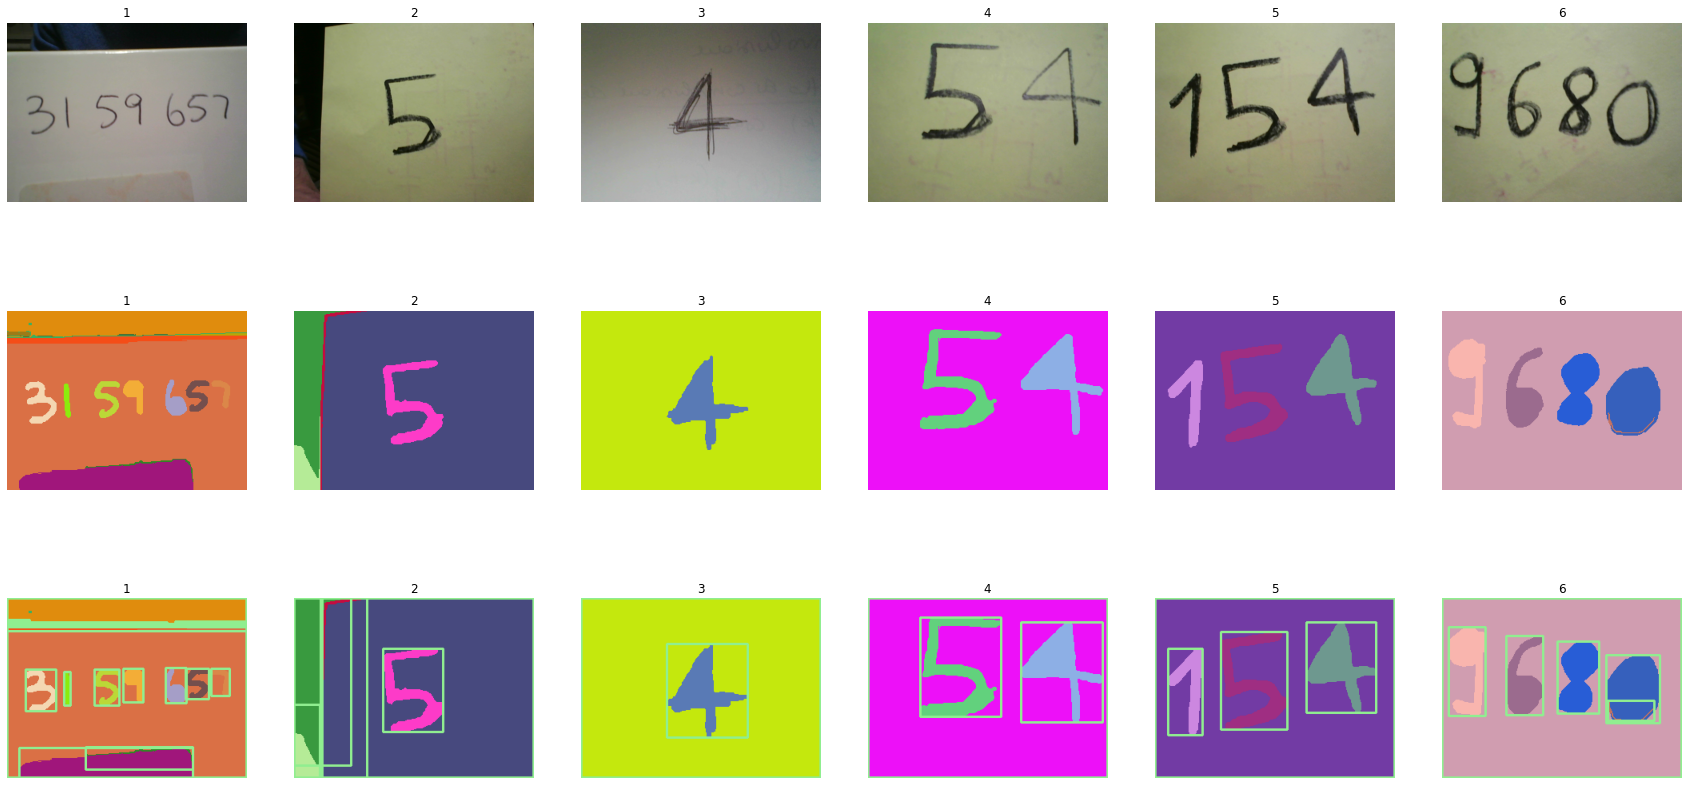

In [5]:
import matplotlib.pyplot as plt

n_images = len(images)

fig = plt.figure(figsize=(30,15))
for i in range(n_images):
    # original
    image = igs[i].img
    label = i + 1
    sp = fig.add_subplot(3, 6, i+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
    # segmented
    image = igs[i].segmented_img
    label = i + 1
    sp = fig.add_subplot(3, 6, i+6+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
    # boxed
    image = igs[i].boxed_img
    label = i + 1
    sp = fig.add_subplot(3, 6, i+12+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
plt.show()